In [1]:
pip install catboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
train_df.head()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


## EDA

In [3]:
print("Training Data Shape:", train_df.shape)
print("\nTest Data Shape:", test_df.shape)
print("\nTraining Data Information:")
print(train_df.info())

# Missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())


Training Data Shape: (140700, 20)

Test Data Shape: (93800, 19)

Training Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                             

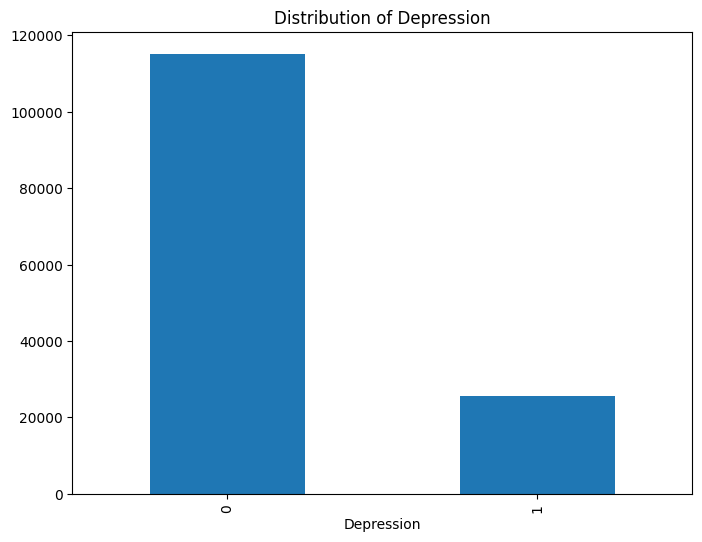

In [4]:
# Distribution of Depression
plt.figure(figsize=(8, 6))
train_df['Depression'].value_counts().plot(kind='bar')
plt.title('Distribution of Depression')
plt.show()

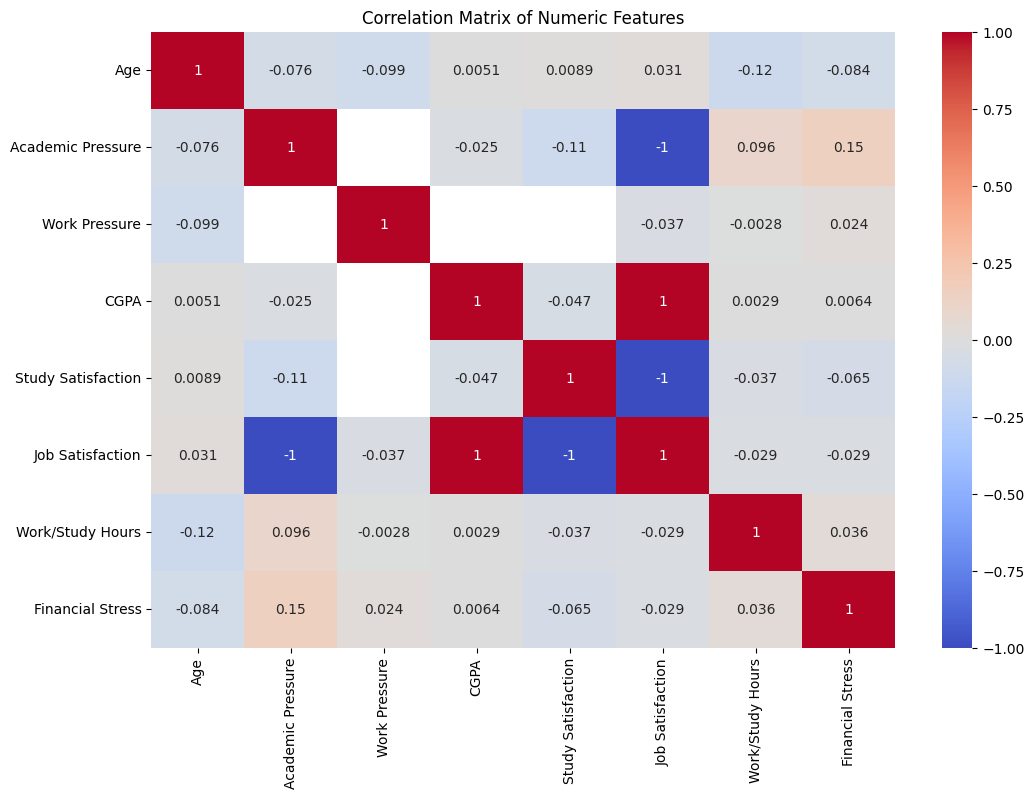

In [5]:
# Correlation Matrix of Numeric Features
numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
               'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
               'Financial Stress']
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


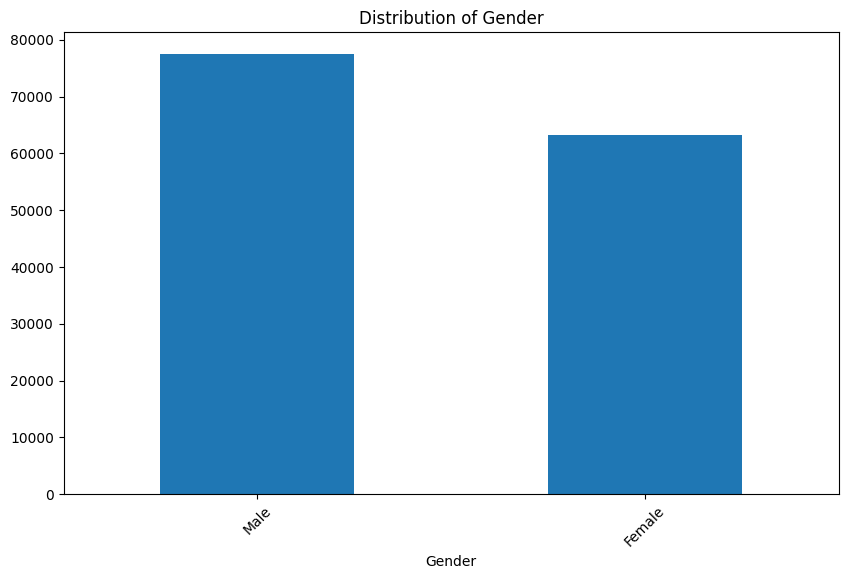

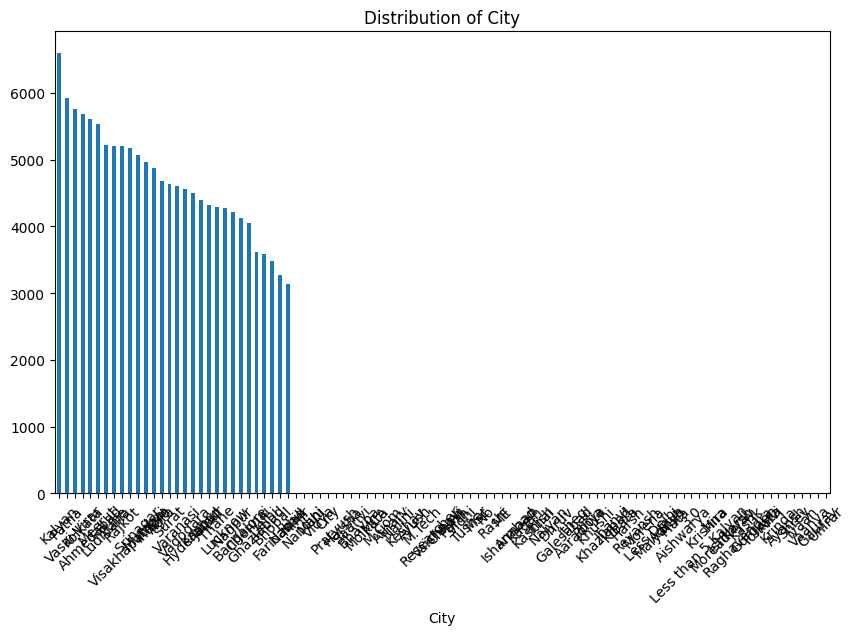

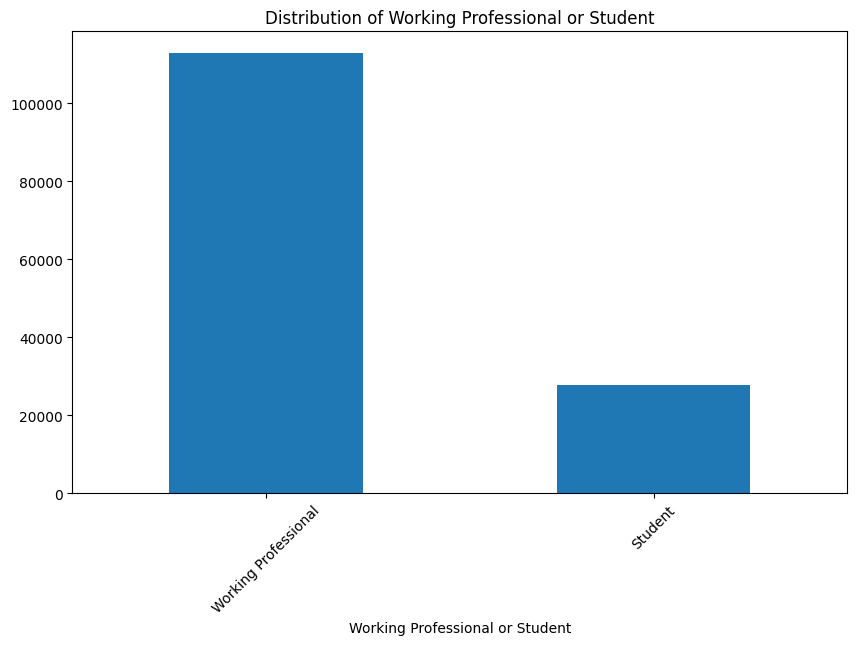

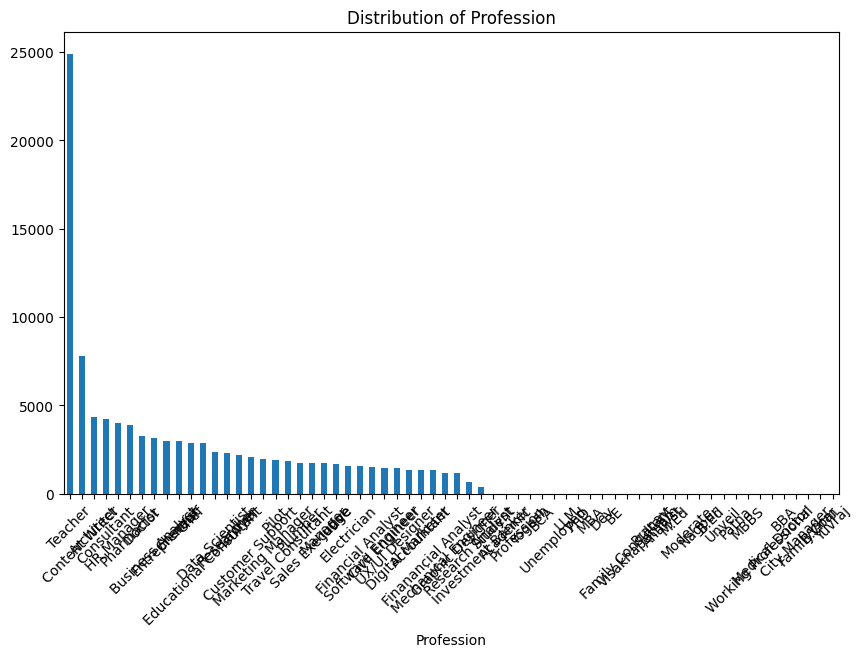

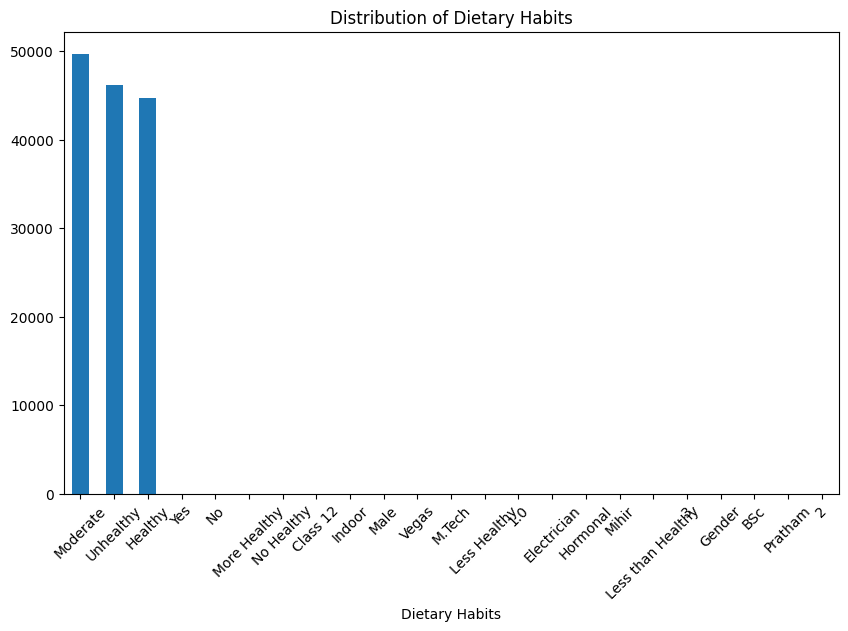

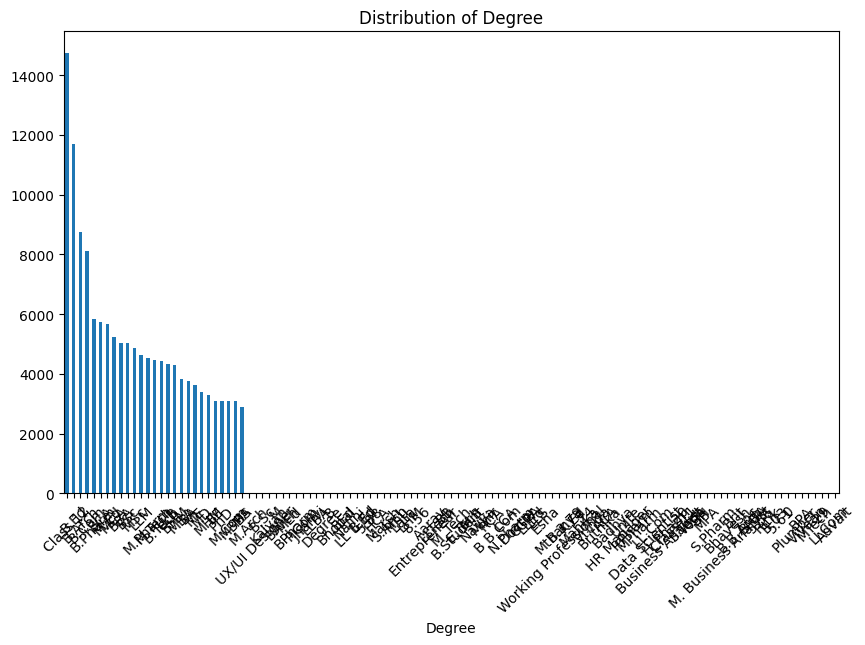

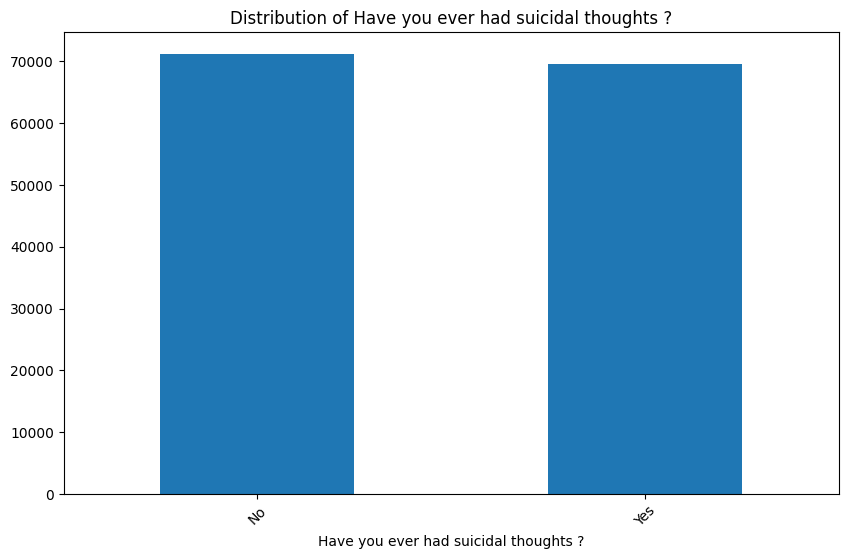

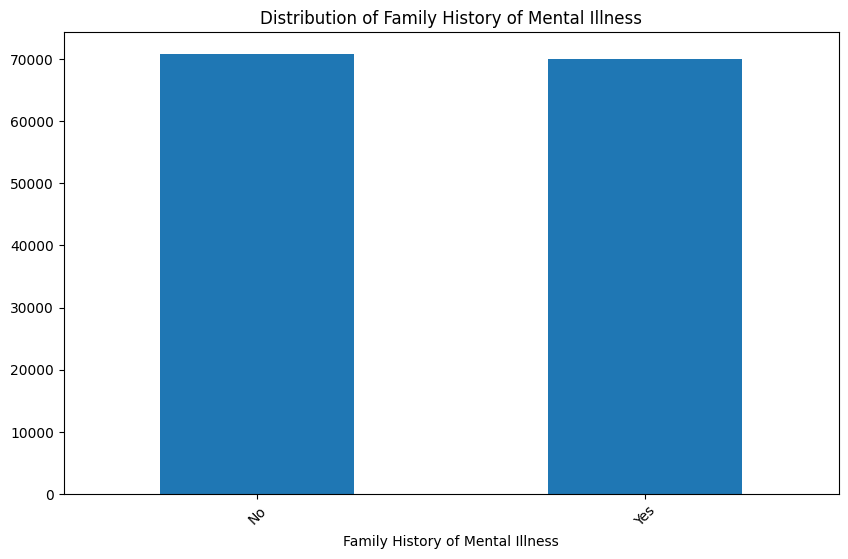

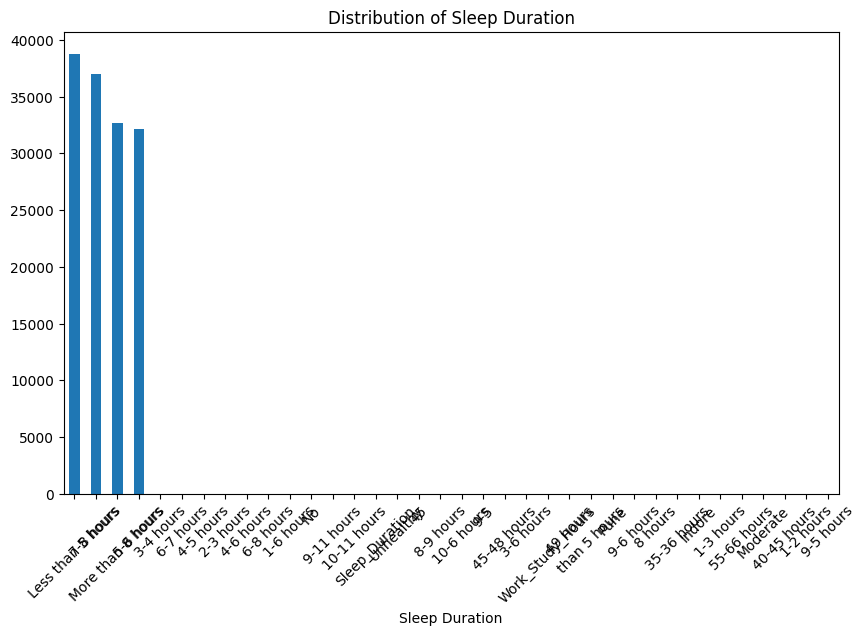

In [6]:
# Categorical features EDA
categorical_columns = ['Gender', 'City', 'Working Professional or Student',
                      'Profession', 'Dietary Habits', 'Degree',
                      'Have you ever had suicidal thoughts ?',
                      'Family History of Mental Illness', 'Sleep Duration']

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    train_df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

## Feature Engineering

In [7]:
def create_feature_interactions(df):
    df = df.copy()

    df['pressure_interaction'] = df['Academic Pressure'] * df['Work Pressure']
    df['satisfaction_interaction'] = df['Study Satisfaction'] * df['Job Satisfaction']
    df['stress_pressure_ratio'] = df['Financial Stress'] / (df['Work Pressure'] + 1)
    df['efficiency_ratio'] = df['Study Satisfaction'] / (df['Work/Study Hours'] + 1)
    df['total_pressure'] = df['Academic Pressure'] + df['Work Pressure'] + df['Financial Stress']
    df['mental_health_risk'] = df['total_pressure'] * (10 - (df['Study Satisfaction'] + df['Job Satisfaction'])/2)

    return df

train_df = create_feature_interactions(train_df)
test_df = create_feature_interactions(test_df)

# Feature scaling
numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
               'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
               'Financial Stress', 'pressure_interaction', 'satisfaction_interaction',
               'stress_pressure_ratio', 'efficiency_ratio', 'total_pressure',
               'mental_health_risk']

scaler = StandardScaler()
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [8]:
# one-hot encoding
categorical_columns = ['Name', 'Gender', 'City', 'Working Professional or Student',
                      'Profession', 'Dietary Habits', 'Degree',
                      'Have you ever had suicidal thoughts ?',
                      'Family History of Mental Illness', 'Sleep Duration']

for col in categorical_columns:
    dummy_train = pd.get_dummies(train_df[col], prefix=col)
    dummy_test = pd.get_dummies(test_df[col], prefix=col)

    for column in dummy_train.columns:
        if column not in dummy_test.columns:
            dummy_test[column] = 0
    for column in dummy_test.columns:
        if column not in dummy_train.columns:
            dummy_train[column] = 0

    dummy_test = dummy_test[dummy_train.columns]

    train_df = train_df.drop(col, axis=1)
    test_df = test_df.drop(col, axis=1)
    train_df = pd.concat([train_df, dummy_train], axis=1)
    test_df = pd.concat([test_df, dummy_test], axis=1)

<ipython-input-8-267bc7adf305>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummy_test[column] = 0
<ipython-input-8-267bc7adf305>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummy_test[column] = 0
<ipython-input-8-267bc7adf305>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dummy_test[c

## Modeling

In [9]:
# Model training
y_train = train_df['Depression']
X_train = train_df.drop(['Depression', 'id'], axis=1)
X_test = test_df.drop(['id'], axis=1)

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=3,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=7,
    num_leaves=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

catboost = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    depth=7,
    l2_leaf_reg=3,
    subsample=0.8,
    colsample_bylevel=0.8,
    random_state=42,
    verbose=0,
    thread_count=-1
)

# Voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('catboost', catboost)
    ],
    voting='soft',
    weights=[1.2, 1.0, 1.1],
    n_jobs=-1
)

print("Training ensemble model...")
voting_clf.fit(X_train, y_train)

Training ensemble model...


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.2,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate...
                                            multi_strategy=None,
                                            n_estimators=2000, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm',
                              LGBMClassifier(colsample_bytree=0.8,
                                             learning_rate=0.01, max_depth=7,
                                             n_estimators=2000, n_jobs=-1,
                                             num_leaves=100, random_state=42,
                                             subsample=0.8)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x78fcabaa7a30>)],
                 n_jobs=-1, voting='soft', weights=[1.2, 1.0, 1.1])

In [10]:
# Make predictions
predictions = voting_clf.predict(X_test)

submission = pd.DataFrame({
    'id': test_df['id'].values,
    'Depression': predictions.astype(int)
})

submission = submission.sort_values('id').reset_index(drop=True)
submission.to_csv('sample_submission.csv', index=False)
print("Submission file created.")

Submission file created.
